In [1]:
%%time

import glob
import json
import pandas as pd
import tensorflow as tf
import numpy as np
import spacy
import re
import string
import gensim
import os

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA, NMF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import matplotlib.pyplot as plt
import en_core_web_lg
import pyLDAvis
#import pyLDAvis.sklearn
from langdetect import detect
from wordcloud import WordCloud
from yellowbrick.text import TSNEVisualizer, UMAPVisualizer
from yellowbrick.features import PCA
from yellowbrick.cluster import SilhouetteVisualizer

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')


/home/prajakta/anaconda3/envs/covid_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


CPU times: user 2.87 s, sys: 528 ms, total: 3.4 s
Wall time: 2.95 s


## Data loading and cleaning
   1. Load papers into a dataframe.
   2. Filter papers without an abstract or body text.
   3. Filter non-english papers.

In [2]:
%%time

path = '/home/prajakta/Documents/SharpestMinds/COVID-analysis/data/*.json'
files = glob.glob(path)

papers = []
for file in files:
    with open(file) as json_file:
            text = json.load(json_file)
            papers.append([text['paper_id'],text['title'], text['bodytext'], text['abstract']])
            
data = pd.DataFrame(papers, columns = ['paper_id','title', 'bodytext', 'abstract'])

filter = (data.abstract != "") & (data.bodytext != "")
data = data[filter]

data['len_bt'] = data.bodytext.map(lambda x: len(x.split(" ")))
data['len_ab'] = data.abstract.map(lambda x: len(x.split(" ")))


data.query('len_bt>=10 and len_ab >=10', inplace = True)

#identify languages of texts to filter out non-english papers
data['bt_lang'] = data.bodytext.map(lambda x: detect(x))
data['ab_lang'] = data.abstract.map(lambda x: detect(x))

#use only english papers
data = data[(data['bt_lang'] == 'en') & (data['ab_lang'] == 'en')]
data.head()

CPU times: user 4min 42s, sys: 1.62 s, total: 4min 43s
Wall time: 4min 43s


,paper_id,title,bodytext,abstract,len_bt,len_ab,bt_lang,ab_lang
0,17413f651645c2b9c92555e9ce1404b9290eccab,Non-human primate orthologues of TMPRSS2 cleav...,a1111111111 a1111111111 a1111111111 a11111111...,"The cellular serine protease TMPRSS2, a membe...",3544,267,en,en
3,ab8c1e32b66b02cd703799df3d2ee37a1cb369b7,Enhanced protection in mice induced by immuniz...,Middle East respiratory syndrome coronavirus ...,The persistent public health threat of infect...,4250,224,en,en
4,685efeb0ad4c214b8295dc4f723c3269464772d8,viruses Isolation of a Novel Fusogenic Orthore...,Bats have been increasingly associated with e...,We report on the isolation of a novel fusogen...,4515,155,en,en
5,09ccb3b9fece55e72c3acb85c4259de62a9c9e0c,Association of herd BRSV and BHV-1 seroprevale...,Bovine respiratory disease (BRD) incorporates...,Background: The aim of this study was to dete...,4393,275,en,en
7,93d080273b1f33330243dd140a35ba890ddd2973,The determinants and consequences of adult nur...,Nurses leaving their jobs or leaving the prof...,Background: Nurses leaving their jobs and the...,7160,298,en,en


## Text pre-processing
 - Tokenization 
 - Removal of stop words
 - Removal of special characters and numbers
 - Lemmatization
 - Lowercase all text
 - Retained only alphabetic characters

In [3]:
def clean_text(bodytext):
    cleaned = []
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table 
    table = str.maketrans('', '', string.punctuation)
    for word in bodytext:
        if word.is_stop == False:
            words = str(word.lemma_)       
            words = words.lower()
            words = words.translate(table)
            words = re_print.sub('', words) 
            if words.isalpha() == True:
                cleaned.append(words)
    return cleaned

#### Apply text pre-processing on abstracts
Since an abstract is a summary of the entire paper, they alone are used for cluster analysis.

In [4]:
%%time
nlp = en_core_web_lg.load()
ab_str = []
for i in range(len(data)):
    abstract = nlp(data.iloc[i].abstract)
    ab_clean = clean_text(abstract)
    ab_str.append((' ').join(ab_clean))
data['ab_clean'] = ab_str


CPU times: user 5min 7s, sys: 948 ms, total: 5min 8s
Wall time: 5min 8s


## Cluster analysis
1. Identify right number of clusters using Silhouette score, Davies-Bouldin score.
2. Identify optimal min_df/max_df to get the document-term matrix 

### Explore Silhouette/Davies-Bouldin score to find the optimal cluster number.
Looking at the chart below, cluster numbers 8 - 10 seem reasonable as both the scores are reasonably low. For K = 5, Silhouette score is positive. However, Davies-Bouldin score is a little high.  
Clusters > 10 have lower scores, however, the clusters are too many to explore. 

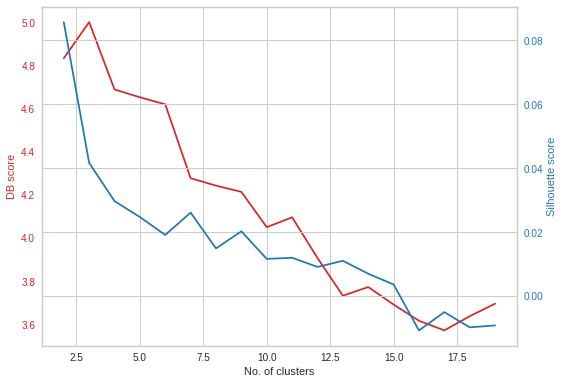

In [7]:
cluster_num = [i for i in range(2,20)]
db_score = []
sil_score = []


for i in cluster_num:
    model_i = KMeans(i).fit(doc_term) 
    db_score.append(davies_bouldin_score(doc_term.toarray(), model_i.labels_))
    sil_score.append(silhouette_score(doc_term, model_i.labels_))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('No. of clusters')
ax1.set_ylabel('DB score', color=color)
ax1.plot(cluster_num, db_score, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.yaxis.grid(False)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Silhouette score', color=color) 
ax2.plot(cluster_num, sil_score, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()

### Explore silhouette scores for optimal values of min_df/max_df
From the chart below, silhouette score is the best for (min_df, max_df) = (0.1, 0.12) but the vocabulary is too small.~300 papers don't have any term in the document-term matrix. 
The next best score can be considered for (min_df,max_df) = (0.09, 0.12). With this score we retain ~98.8% of total papers.

In [8]:
%%time
sil_scores = {}
sil_papers = {}
i = 0.01

while (i <= 0.10):
    j = 0.20
    while (j>=0.11):
        cnt_vec = CountVectorizer(min_df = round(i,2), max_df = round(j,2), binary = True)  #max_df = 0.20 #
        doc_term = cnt_vec.fit_transform(data['ab_clean'])
        model_9 = KMeans(9).fit(doc_term)
        num_papers = np.array((doc_term.sum(axis=1)))
        dict_key = str(round(i,2))+','+str(round(j,2))
        sil_scores[dict_key]= silhouette_score(doc_term, model_9.labels_) #*np.count_nonzero(num_papers)
        sil_papers[dict_key]= np.count_nonzero(num_papers) 
        
        j -= 0.01
    i += 0.01

CPU times: user 2h 26min 5s, sys: 31min 15s, total: 2h 57min 21s
Wall time: 2h 14min 42s


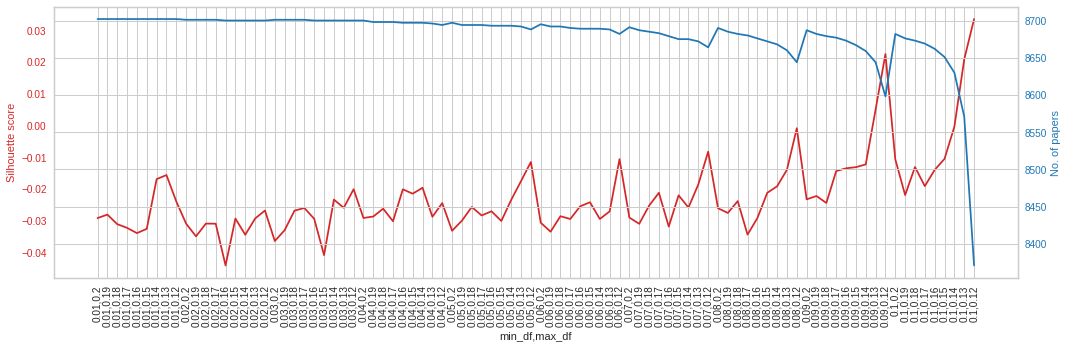

In [9]:
fig, ax1 = plt.subplots(figsize=(15,5))

color = 'tab:red'
ax1.set_xlabel('min_df,max_df')
ax1.set_ylabel('Silhouette score', color=color)
plt.xticks(rotation = 90)
ax1.plot(*zip(*sil_scores.items()), color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.yaxis.grid(False)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('No. of papers', color=color) 
ax2.plot(*zip(*sil_papers.items()), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()

### Create document-term matrix using a Binary CountVectorizer
After multiple iterations of exploring the vocabulary list and silhouette plots to identify optimal values of min_df and max_df, 9% and 12% were chosen respectively. 
To keep frequently co-occuring terms together, I'm using ngram range 1-3.
The document-term matrix has total of 69 terms. 

In [10]:
cnt_vec = CountVectorizer(min_df = 0.09, max_df = 0.12, binary = True, ngram_range=(1,3)) # min_df = 0.07, max_df = 0.12
doc_term = cnt_vec.fit_transform(data['ab_clean'])
doc_term.shape

(8702, 69)

#### By ignoring terms that appear less than 9% of documents (infrequent) and more than 12% of the documents (too frequent), we retain 98.8% documents with atleast one term in the document-term matrix. 

In [11]:
np.count_nonzero(np.array((doc_term.sum(axis=1))))

8601

#### The histogram below gives the distribution of total number of terms from each paper in the document-term matrix.Most of the papers have 5 - 10 words in them. 

(array([1.313e+03, 3.868e+03, 2.574e+03, 6.340e+02, 1.680e+02, 9.400e+01,
        3.800e+01, 8.000e+00, 2.000e+00, 3.000e+00]),
 array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.]),
 <a list of 10 Patch objects>)

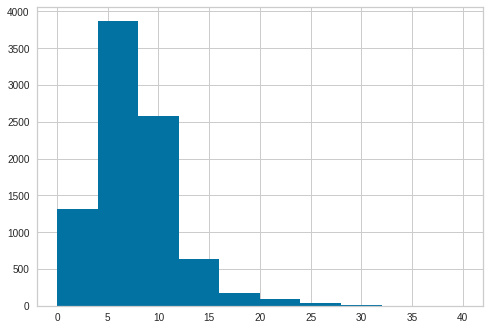

In [12]:
plt.hist(np.array((doc_term.sum(axis=1))))

### Silhouette plots to find the optimal number of clusters
The average silhouette score for K >= 6 is close to 0 indicating overlapping clusters. Looking at the shape of some clusters in the plot, they also have poor cluster quality. 
Cluster number 2 - 5 have a positive avg. silhouette score. Clusters 4 & 5 look like a decent size for exploration. However, cluster number 5 has two clusters that don't seem like good clusters. Hence, I'll use 4 clusters for my analysis.

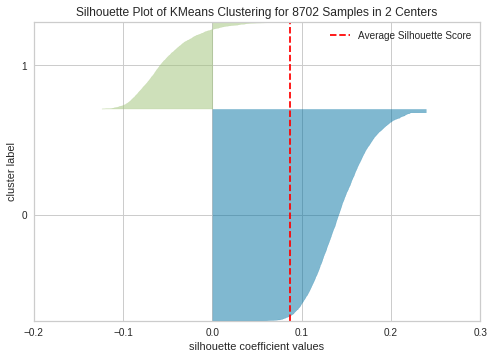

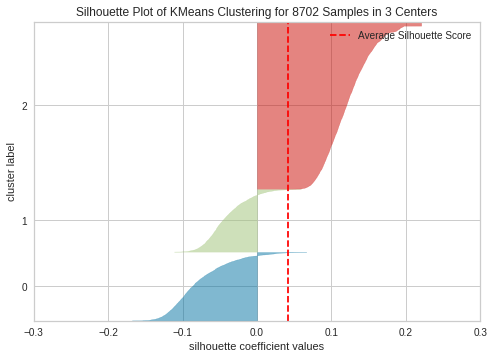

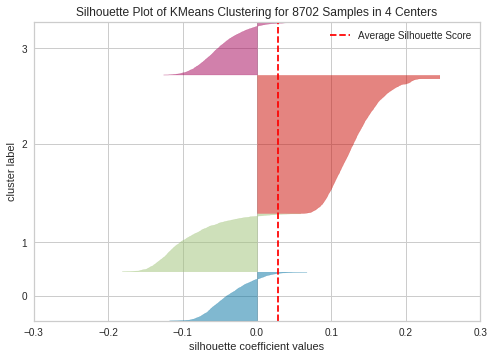

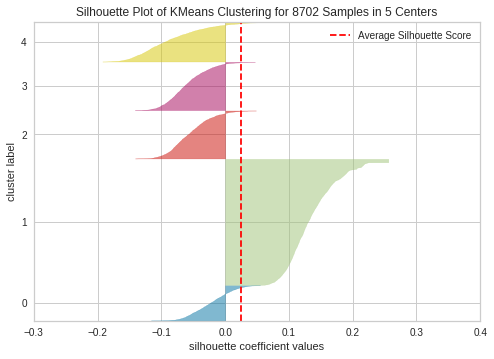

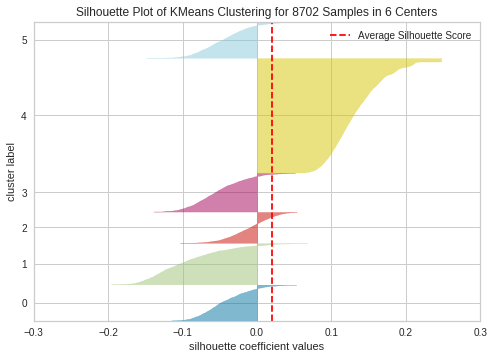

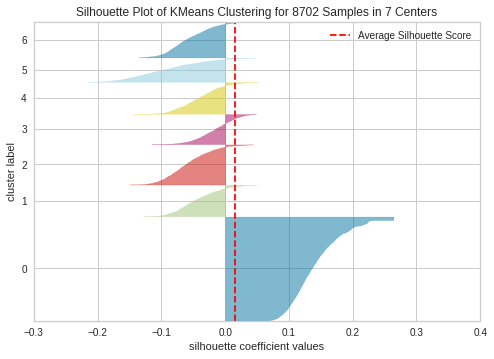

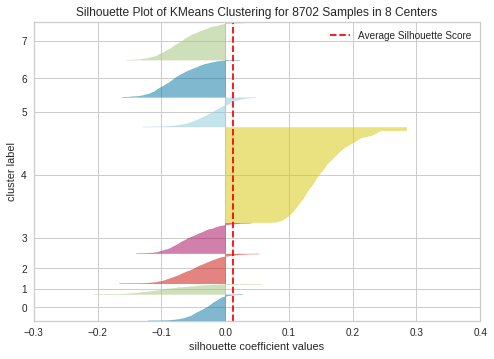

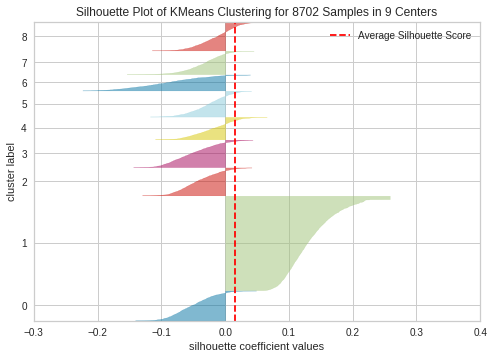

CPU times: user 3min 12s, sys: 4.92 s, total: 3min 17s
Wall time: 3min 16s


In [13]:
%%time

for i in range(2,10):
    model = KMeans(i) # make silhoutte plots

    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(doc_term) 

    #data['clusters_cvb'] = model.labels_.tolist()
    visualizer.show()    

#### Fit a K-means model (K=4) to the document-term matrix (binary vectorizer)

In [14]:
model = KMeans(4) # make silhoutte plots
model.fit(doc_term) 
data['clusters_cvb'] = model.labels_.tolist()

#### Fit a t-SNE model to visualize the clusters in two-dimensional space. 
Overall, 3 out of 4 clusters seem to be pretty well defined. 

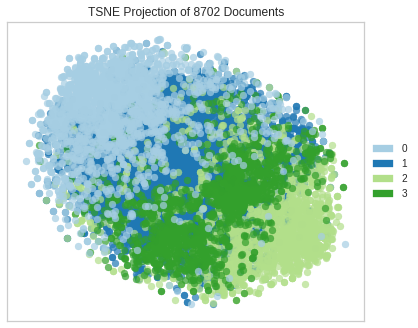

In [15]:
#colors = ['red','blue','green','yellow','grey','orange','maroon','cyan','brown']
from yellowbrick.style import set_palette
set_palette('paired')
y_cvb = data['clusters_cvb']

tsne = TSNEVisualizer()
tsne.fit(doc_term,y_cvb)
tsne.show()

#### Creating document-term matrix using non-binary CountVectorizer. 

In [16]:
cnt_vec_nb = CountVectorizer(min_df = 0.09, max_df = 0.12, binary = False)  # min_df = 0.05, max_df = 0.11
doc_term_nb = cnt_vec_nb.fit_transform(data['ab_clean'])
doc_term_nb.shape

(8702, 68)

#### For all K, silhouette plots show most of the papers belong to a single cluster.

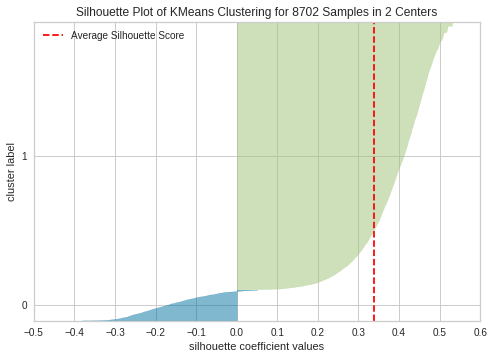

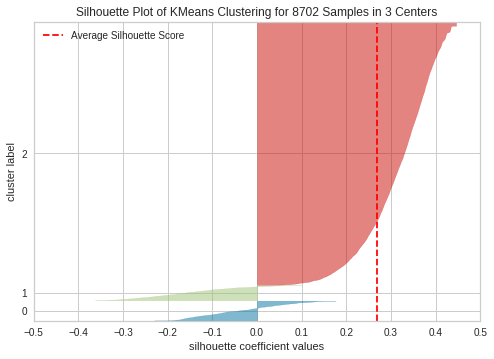

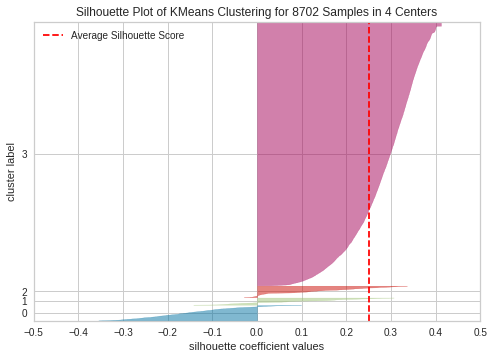

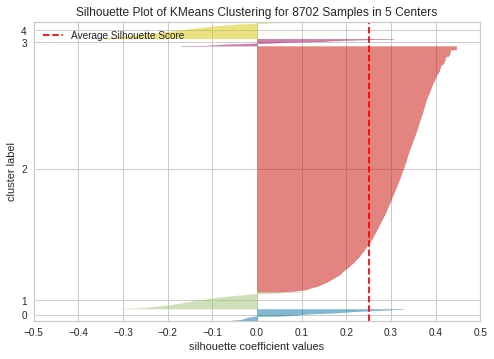

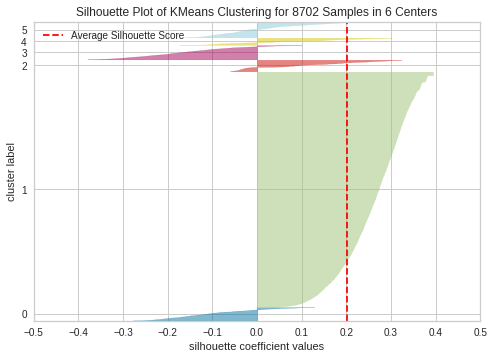

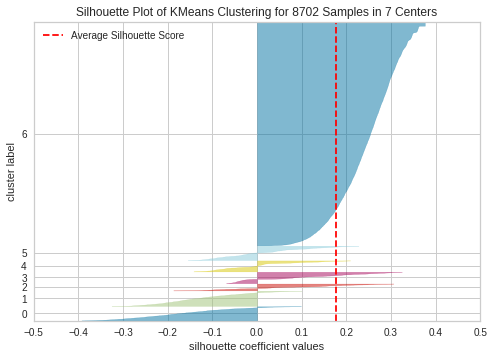

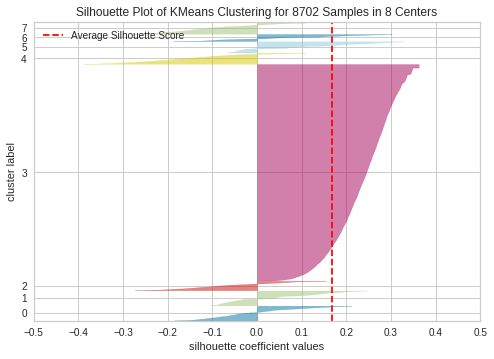

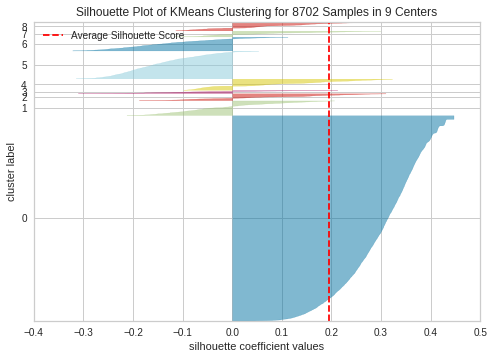

CPU times: user 2min 21s, sys: 4.9 s, total: 2min 26s
Wall time: 2min 24s


In [17]:
%%time

for i in range(2,10):
    model_nb = KMeans(i)

    visualizer_nb = SilhouetteVisualizer(model_nb, colors='yellowbrick')
    visualizer_nb.fit(doc_term_nb) 

    data['clusters_cvnb'] = model_nb.labels_.tolist()
    visualizer_nb.show()   

#### Creating TF-IDF matrix

In [18]:
%%time
tfidf_vectorizer = TfidfVectorizer(min_df = 0.09, max_df = 0.12, ngram_range = (1,3))  #min_df = 0.05, max_df = 0.11
tfidf_matrix = tfidf_vectorizer.fit_transform(data.ab_clean)
tf_idf = pd.DataFrame(tfidf_vectorizer.transform(data.ab_clean).toarray(), columns = sorted(tfidf_vectorizer.vocabulary_.keys()))
tf_idf.shape

CPU times: user 10.6 s, sys: 165 ms, total: 10.8 s
Wall time: 10.8 s


(8702, 69)

#### From the silhouette plots, TF-IDF matrix also does not generate good clusters for any K.

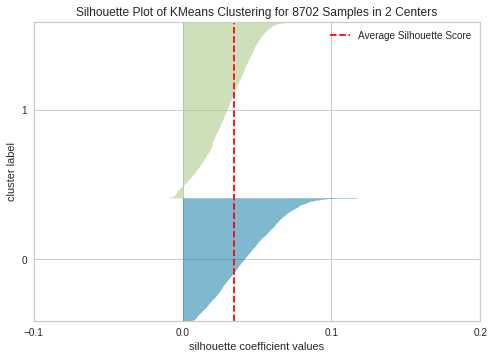

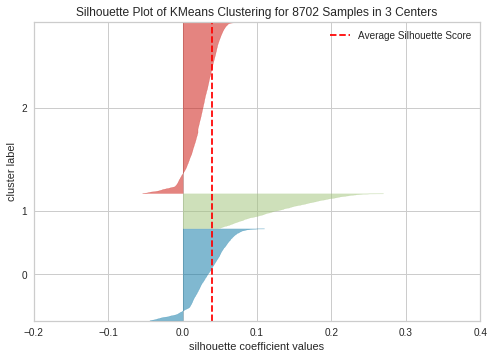

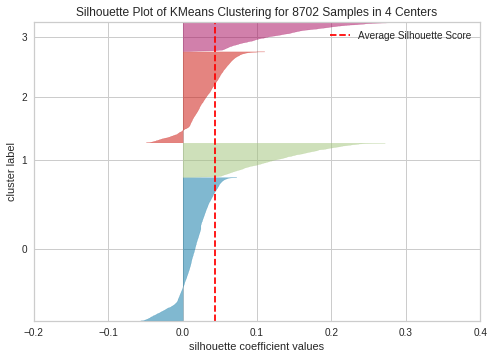

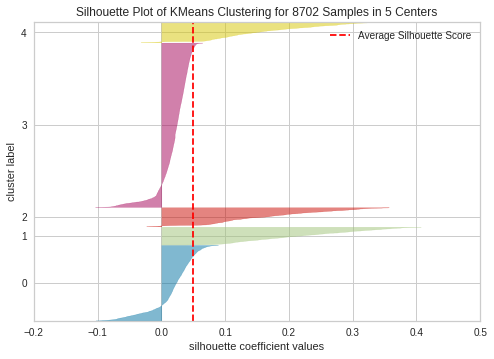

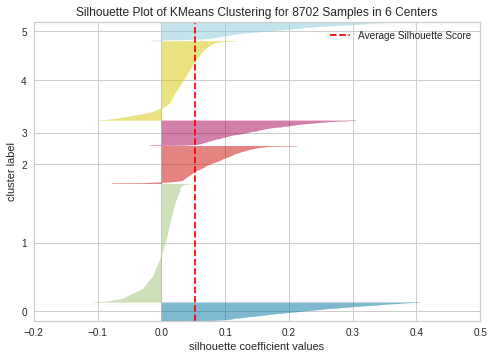

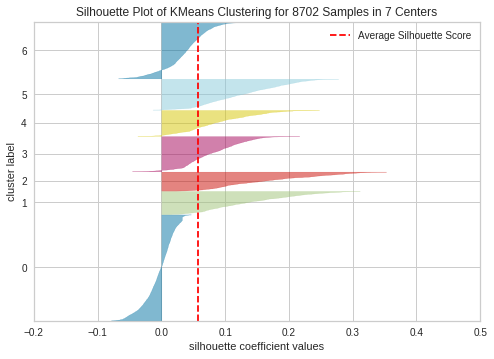

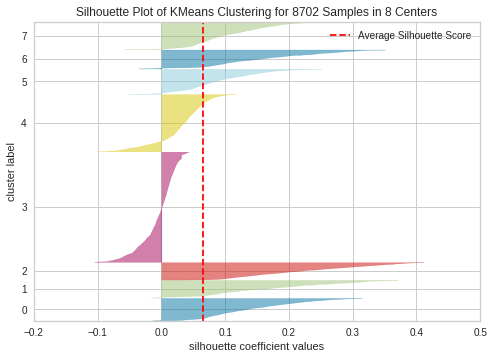

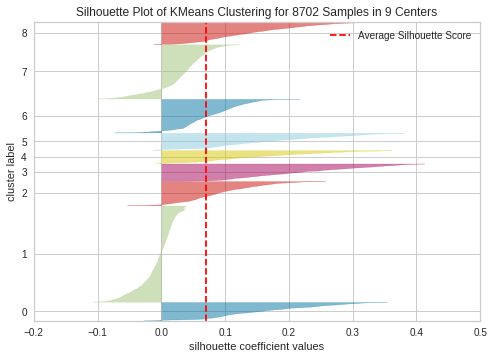

CPU times: user 45.3 s, sys: 43.9 s, total: 1min 29s
Wall time: 22.9 s


In [19]:
%%time

for i in range(2,10):
    model_tfidf = KMeans(i)
    visualizer = SilhouetteVisualizer(model_tfidf, colors='yellowbrick')

    visualizer.fit(tf_idf)        # Fit the data to the visualizer
    #data['clusters'] = model_tfidf.labels_.tolist()
    visualizer.show() 

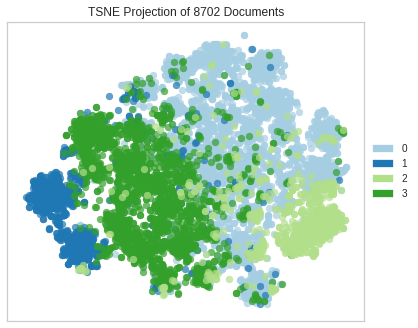

CPU times: user 2min 19s, sys: 4.29 s, total: 2min 23s
Wall time: 30.1 s


In [20]:
%%time
model = KMeans(4) # make silhoutte plots
model.fit(tf_idf) 
data['clusters'] = model.labels_.tolist()

y = data['clusters']

tsne = TSNEVisualizer()
tsne.fit(tf_idf,y)
tsne.show()

### Topic Modelling

#### To perform topic modelling, I fit the data with LDA and NMF using binary count vectorizer (since it generated better clusters than non-binary and TF-IDF). 
Looking at the top 10 words from each topic, LDA and NMF seem to be identifying similar topics.

The following topics were labelled after looking at the top 10 words from each topic and randomly  sampling few papers from each topic.

##### Topic 0: Use of PCR in detection and monitoring of viruses 
##### Topic 1: Epidemiological models, public healths
##### Topic 2: Research on mice to study immune responses 
##### Topic 3: Viral protein structure

#### LDA using binary count vectorizer

In [21]:
def print_topics(model, cnt_vec, n_top_words):
    words = cnt_vec.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
number_topics = 4
number_words = 10

lda_cvb = LDA(n_components=number_topics, n_jobs=50)
doc_topic = lda_cvb.fit_transform(doc_term)

print("Topics found via LDA:")
print_topics(lda_cvb, cnt_vec, number_words) 



Topics found via LDA:

Topic #0:
bind interaction structure receptor complex cellular mediate site acid like

Topic #1:
pcr detection total age collect respectively perform confirm aim common

Topic #2:
public transmission emerge spread research epidemic information measure recent improve

Topic #3:
anti mouse therapeutic antiviral antibody immune response agent express challenge furthermore


In [22]:
max_lda = []
lda_score = []
lda_max_score = []
for i in range(doc_topic.shape[0]):
    max_lda.append(doc_topic[i].argmax()) # analysis on topic distribution
    lda_score.append(doc_topic[i])
    lda_max_score.append(doc_topic[i].max())
data['lda_clusters'] = max_lda
data['lda_score'] = lda_score
data['lda_max_score'] = lda_max_score

In [23]:
#doc_topic = lda_cvb.transform(doc_term)
max_ = []
for i in range(doc_topic.shape[0]):
    max_.append(doc_topic[i].argmax())
data['lda_clusters'] = max_

#### Non-negative matrix factorization

The following topics were labelled after looking at the top 10 words from each topic and randomly  sampling few papers from each topic.

##### Topic 0: Viral protein structure
##### Topic 1: Use of PCR in detection and monitoring of viruses
##### Topic 2: Epidemiological models, public health
##### Topic 3: Research on mice to study immune responses

In [24]:
number_topics = 4
number_words = 10

nmf = NMF(n_components=number_topics, solver="mu", random_state = 3)
W = nmf.fit_transform(doc_term)
H = nmf.components_
print("Topics found via NMF:")
print_topics(nmf, cnt_vec, number_words)

#sample of 10 papers and look to see if topics make sense
#scoring function: 

Topics found via NMF:

Topic #0:
bind interaction cellular acid structure like molecular contain complex receptor

Topic #1:
pcr collect age detection total aim common perform respectively day

Topic #2:
public transmission emerge spread epidemic research recent information measure individual

Topic #3:
mouse antibody immune response anti express therapeutic challenge day antiviral receptor


In [25]:
max_ = []
nmf_score = []
nmf_max_score = []
for i in range(W.shape[0]):
    max_.append(W[i].argmax()) # analysis on topic distribution
    nmf_score.append(W[i])
    nmf_max_score.append(W[i].max())
data['nmf_clusters'] = max_
data['nmf_score'] = nmf_score
data['nmf_max_score'] = nmf_max_score

In [26]:
data['nmf_clusters'].value_counts().sort_index()

0    2857
1    2345
2    1952
3    1548
Name: nmf_clusters, dtype: int64

In [27]:
data['lda_clusters'].value_counts().sort_index()

0    2471
1    2351
2    2285
3    1595
Name: lda_clusters, dtype: int64

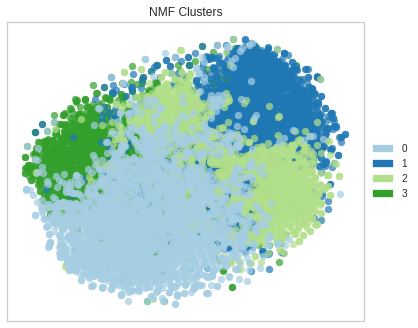

In [28]:
tsne = TSNEVisualizer(title = 'NMF Clusters')
tsne.fit(doc_term,data['nmf_clusters'])
tsne.show()

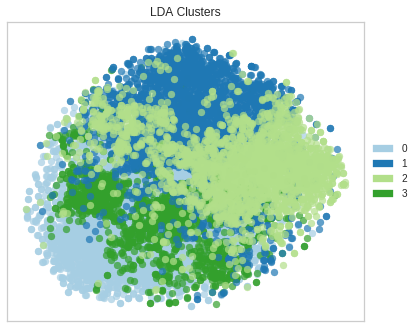

In [29]:
tsne = TSNEVisualizer(title = 'LDA Clusters')
tsne.fit(doc_term,data['lda_clusters'])
tsne.show()